## Denoising autoencoder with a skip connection in the encoder 

In [2]:
import platform
print(platform.machine())
print(platform.version())
print(platform.platform())
print(platform.uname())
print('Platform System: ' + platform.system())
print(platform.processor())
print(platform.python_compiler())

AMD64
10.0.17763
Windows-10-10.0.17763-SP0
uname_result(system='Windows', node='DESKTOP-MDSP2HJ', release='10', version='10.0.17763', machine='AMD64', processor='Intel64 Family 6 Model 158 Stepping 10, GenuineIntel')
Platform System: Windows
Intel64 Family 6 Model 158 Stepping 10, GenuineIntel
MSC v.1900 64 bit (AMD64)


In [3]:
import sys
import numpy
import matplotlib
import pandas
import keras

Using TensorFlow backend.


In [4]:
print('Python: {}'.format(sys.version))
print('numpy: {}'.format(numpy.__version__))
print('matplotlib: {}'.format(matplotlib.__version__))
print('pandas: {}'.format(pandas.__version__))
print('keras: {}'.format(keras.__version__))

Python: 3.7.1 | packaged by conda-forge | (default, Mar 13 2019, 13:32:59) [MSC v.1900 64 bit (AMD64)]
numpy: 1.16.2
matplotlib: 3.0.3
pandas: 0.24.2
keras: 2.2.4


In [5]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
import keras
from keras.layers import Activation, Dense, Input
from keras.layers import Conv2D, Flatten
from keras.layers import Reshape, Conv2DTranspose
from keras.models import Model
from keras import backend as K
from keras.datasets import mnist
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import TensorBoard
import time
import pickle
import sys

start = time.time();

np.random.seed(42)

In [6]:
import numpy as np

IMG_SIZE = 32

x_train = pickle.load(open("x_train.pickle","rb"))
x_test = pickle.load(open("x_test.pickle", "rb"))

x_test = np.array(x_test).reshape(-1, IMG_SIZE, IMG_SIZE, 1)
x_train = np.array(x_train).reshape(-1, IMG_SIZE, IMG_SIZE, 1)

x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255

noise_factor = 0.1
x_train_noisy = x_train + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_train.shape) 
x_test_noisy = x_test + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_test.shape) 

x_train = np.clip(x_train, 0., 1.)
x_test = np.clip(x_test, 0., 1.)

print(x_train[150].squeeze().max())
print(x_train_noisy[150].squeeze().max())
print(x_test[150].squeeze().max())
print(x_test_noisy[150].squeeze().max())

0.92156863
1.0927069543942936
0.75686276
0.9297173962794395


In [7]:
print(x_train.shape)
print(x_train_noisy.shape)

print(x_test.shape)
print(x_test_noisy.shape)

(10997, 32, 32, 1)
(10997, 32, 32, 1)
(1499, 32, 32, 1)
(1499, 32, 32, 1)


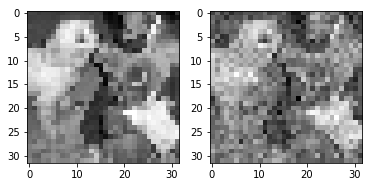

In [8]:
plt.subplot(1,2,1)
plt.imshow(x_train[150].squeeze(),cmap="gray")
plt.subplot(1,2,2)
plt.imshow(x_train_noisy[150].squeeze(),cmap="gray")

In [9]:
print(x_test.shape)
print(x_test_noisy.shape)

(1499, 32, 32, 1)
(1499, 32, 32, 1)


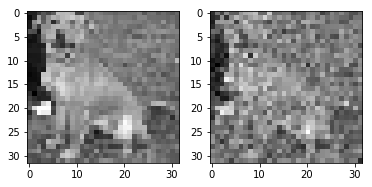

In [10]:
plt.subplot(1,2,1)
plt.imshow(x_test[750].squeeze(),cmap="gray")
plt.subplot(1,2,2)
plt.imshow(x_test_noisy[750].squeeze(),cmap="gray")

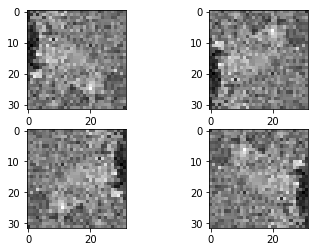

In [11]:
plt.subplot(2,2,1)
plt.imshow(x_test_noisy[750].squeeze(),cmap="gray")
plt.subplot(2,2,2)
plt.imshow(np.flip(x_test_noisy[750],axis=0).squeeze(),cmap="gray")
plt.subplot(2,2,3)
plt.imshow(np.flip(x_test_noisy[750],axis=1).squeeze(),cmap="gray")
plt.subplot(2,2,4)
plt.imshow(np.flip(np.flip(x_test_noisy[750],axis=1),axis=0).squeeze(),cmap="gray")

In [12]:
# x_test2 = np.flipud(x_test)
x_test2 = x_test[...,::-1,:] #flip horiz
x_test3 = x_test[:,::-1,...] #flip vert
x_test4 = x_test3[...,::-1,:] #flip both
x_test = np.append(x_test,x_test2)
x_test = np.append(x_test,x_test3)
x_test = np.append(x_test,x_test4)

x_train2 = x_train[...,::-1,:] #flip horiz
x_train3 = x_train[:,::-1,...] #flip vert
x_train4 = x_train3[...,::-1,:] #flip both
x_train = np.append(x_train,x_train2)
x_train = np.append(x_train,x_train3)
x_train = np.append(x_train,x_train4)

x_train_noisy2 = x_train_noisy[...,::-1,:] #flip horiz
x_train_noisy3 = x_train_noisy[:,::-1,...] #flip vert
x_train_noisy4 = x_train_noisy3[...,::-1,:] #flip both
x_train_noisy = np.append(x_train_noisy,x_train_noisy2)
x_train_noisy = np.append(x_train_noisy,x_train_noisy3)
x_train_noisy = np.append(x_train_noisy,x_train_noisy4)

x_test_noisy2 = x_test_noisy[...,::-1,:] #flip horiz
x_test_noisy3 = x_test_noisy[:,::-1,...] #flip vert
x_test_noisy4 = x_test_noisy3[...,::-1,:] #flip both
x_test_noisy = np.append(x_test_noisy,x_test_noisy2)
x_test_noisy = np.append(x_test_noisy,x_test_noisy3)
x_test_noisy = np.append(x_test_noisy,x_test_noisy4)

In [13]:
print(x_test2.shape)
print(x_test3.shape)
print(x_test4.shape)
print(x_test.shape)

print(x_train2.shape)
print(x_train3.shape)
print(x_train4.shape)
print(x_train.shape)

print(x_test_noisy2.shape)
print(x_test_noisy3.shape)
print(x_test_noisy4.shape)
print(x_test_noisy.shape)

print(x_train_noisy2.shape)
print(x_train_noisy3.shape)
print(x_train_noisy4.shape)
print(x_train_noisy.shape)






(1499, 32, 32, 1)
(1499, 32, 32, 1)
(1499, 32, 32, 1)
(6139904,)
(10997, 32, 32, 1)
(10997, 32, 32, 1)
(10997, 32, 32, 1)
(45043712,)
(1499, 32, 32, 1)
(1499, 32, 32, 1)
(1499, 32, 32, 1)
(6139904,)
(10997, 32, 32, 1)
(10997, 32, 32, 1)
(10997, 32, 32, 1)
(45043712,)


In [14]:
x_test = np.array(x_test).reshape(-1, IMG_SIZE, IMG_SIZE, 1)
x_train = np.array(x_train).reshape(-1, IMG_SIZE, IMG_SIZE, 1)
x_test_noisy = np.array(x_test_noisy).reshape(-1, IMG_SIZE, IMG_SIZE, 1)
x_train_noisy = np.array(x_train_noisy).reshape(-1, IMG_SIZE, IMG_SIZE, 1)

print(x_test.shape)
print(x_train.shape)
print(x_test_noisy.shape)
print(x_train_noisy.shape)

(5996, 32, 32, 1)
(43988, 32, 32, 1)
(5996, 32, 32, 1)
(43988, 32, 32, 1)


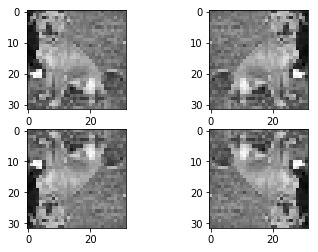

In [15]:
plt.subplot(2,2,1)
plt.imshow(x_test[750].squeeze(),cmap="gray")
plt.subplot(2,2,2)
plt.imshow(x_test2[750].squeeze(),cmap="gray")
plt.subplot(2,2,3)
plt.imshow(x_test3[750].squeeze(),cmap="gray")
plt.subplot(2,2,4)
plt.imshow(x_test4[750].squeeze(),cmap="gray")

In [16]:
print(x_test[0].shape)
print(x_train[0].shape)
print(x_test_noisy[0].shape)
print(x_train_noisy[0].shape)

(32, 32, 1)
(32, 32, 1)
(32, 32, 1)
(32, 32, 1)


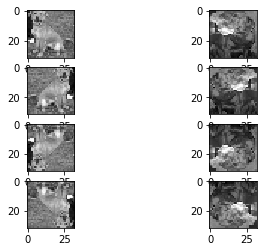

In [17]:
plt.subplot(4,2,1)
plt.imshow(x_test[750].squeeze(),cmap="gray")
plt.subplot(4,2,2)
plt.imshow(x_test[751].squeeze(),cmap="gray")
plt.subplot(4,2,3)
plt.imshow(x_test[750+1499].squeeze(),cmap="gray")
plt.subplot(4,2,4)
plt.imshow(x_test[750+1500].squeeze(),cmap="gray")
plt.subplot(4,2,5)
plt.imshow(x_test[750+1499*2].squeeze(),cmap="gray")
plt.subplot(4,2,6)
plt.imshow(x_test[750+1500*2-1].squeeze(),cmap="gray")
plt.subplot(4,2,7)
plt.imshow(x_test[750+1499*3].squeeze(),cmap="gray")
plt.subplot(4,2,8)
plt.imshow(x_test[750+1500*3-2].squeeze(),cmap="gray")

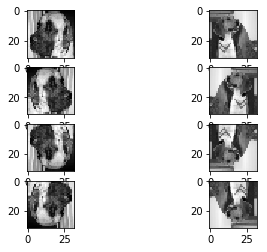

In [18]:
plt.subplot(4,2,1)
plt.imshow(x_train[750].squeeze(),cmap="gray")
plt.subplot(4,2,2)
plt.imshow(x_train[751].squeeze(),cmap="gray")
plt.subplot(4,2,3)
plt.imshow(x_train[750+10997].squeeze(),cmap="gray")
plt.subplot(4,2,4)
plt.imshow(x_train[750+10998].squeeze(),cmap="gray")
plt.subplot(4,2,5)
plt.imshow(x_train[750+10997*2].squeeze(),cmap="gray")
plt.subplot(4,2,6)
plt.imshow(x_train[750+10998*2-1].squeeze(),cmap="gray")
plt.subplot(4,2,7)
plt.imshow(x_train[750+10997*3].squeeze(),cmap="gray")
plt.subplot(4,2,8)
plt.imshow(x_train[750+10998*3-2].squeeze(),cmap="gray")

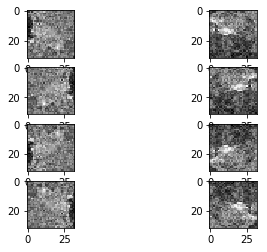

In [19]:
plt.subplot(4,2,1)
plt.imshow(x_test_noisy[750].squeeze(),cmap="gray")
plt.subplot(4,2,2)
plt.imshow(x_test_noisy[751].squeeze(),cmap="gray")
plt.subplot(4,2,3)
plt.imshow(x_test_noisy[750+1499].squeeze(),cmap="gray")
plt.subplot(4,2,4)
plt.imshow(x_test_noisy[750+1500].squeeze(),cmap="gray")
plt.subplot(4,2,5)
plt.imshow(x_test_noisy[750+1499*2].squeeze(),cmap="gray")
plt.subplot(4,2,6)
plt.imshow(x_test_noisy[750+1500*2-1].squeeze(),cmap="gray")
plt.subplot(4,2,7)
plt.imshow(x_test_noisy[750+1499*3].squeeze(),cmap="gray")
plt.subplot(4,2,8)
plt.imshow(x_test_noisy[750+1500*3-2].squeeze(),cmap="gray")

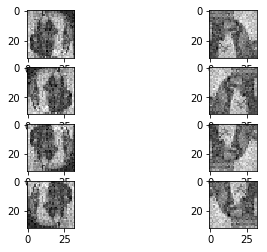

In [20]:
plt.subplot(4,2,1)
plt.imshow(x_train_noisy[750].squeeze(),cmap="gray")
plt.subplot(4,2,2)
plt.imshow(x_train_noisy[751].squeeze(),cmap="gray")
plt.subplot(4,2,3)
plt.imshow(x_train_noisy[750+10997].squeeze(),cmap="gray")
plt.subplot(4,2,4)
plt.imshow(x_train_noisy[750+10998].squeeze(),cmap="gray")
plt.subplot(4,2,5)
plt.imshow(x_train_noisy[750+10997*2].squeeze(),cmap="gray")
plt.subplot(4,2,6)
plt.imshow(x_train_noisy[750+10998*2-1].squeeze(),cmap="gray")
plt.subplot(4,2,7)
plt.imshow(x_train_noisy[750+10997*3].squeeze(),cmap="gray")
plt.subplot(4,2,8)
plt.imshow(x_train_noisy[750+10998*3-2].squeeze(),cmap="gray")

In [29]:
image_size = 32
input_shape = (image_size, image_size, 1)
num_epochs = 5
batch_size = 128
kernel_size = 3
latent_dim = 32

from keras.layers import MaxPooling2D, UpSampling2D, BatchNormalization

input_img = Input(shape=(image_size, image_size, 1),
                  name = 'input')

x = Conv2D(filters = 32,
           kernel_size = (3, 3),
           strides = (1, 1),
           activation='relu',
           padding='same',
           name = 'conv1')(input_img)
x = BatchNormalization()(x)
x  = Activation('relu')(x)
res1 = x


x = MaxPooling2D(pool_size = (2, 2),
                 padding='same',
                 name = "pool1")(x)


x = Conv2D(filters = 32,
           kernel_size = (3, 3),
           strides = (1, 1),
           activation='relu',
           padding='same',
          name = 'conv4')(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
res4 = x

encoded = MaxPooling2D(pool_size = (2, 2),
                       padding='same',
                      name = 'pool2')(x)

shape = K.int_shape(encoded)

# #Latent representation of original image 
x = Flatten()(x)
latent = Dense(units = latent_dim,
               name='latent_vector')(x)

latent_inputs = Input(shape=(latent_dim,)
                      , name='decoder_input')

x = Dense(shape[1] * shape[2] * shape[3])(latent_inputs)
x = Reshape((shape[1], shape[2], shape[3]))(x)

x = Conv2DTranspose(filters = 32, 
                    kernel_size = (3, 3), 
                    strides = (1,1),
                    activation='relu', 
                    padding='same', 
                    name = "conv_transpose1")(encoded)
x = BatchNormalization()(x)
x = Activation('relu')(x)
# x = keras.layers.Add()([res4,x])

x = UpSampling2D(size = (2, 2))(x)
# x = keras.layers.Add()([res3,x])

x = Conv2DTranspose(filters = 32, 
                    kernel_size = (3, 3), 
                    strides = (1,1),
                    activation='relu', 
                    padding='same',
                   name = "conv_transpose2")(x)
x = BatchNormalization()(x)
x = keras.layers.Add()([res4,x])
x = Activation('relu')(x)


x = UpSampling2D(size = (2, 2))(x)


# x = keras.layers.Add()([res2,x])

x = Conv2DTranspose(filters = 32, 
                    kernel_size = (3, 3), 
                    strides = (1,1),
                    activation='relu',
                    padding='same',
                   name = "conv_transpose5")(x)
x = BatchNormalization()(x)
x = keras.layers.Add()([res1,x])
x = Activation('relu')(x)
# x = keras.layers.Add()([res1,x])

decoded = Conv2DTranspose(filters = 1,
                          kernel_size = (3, 3),
                          strides = (1, 1),
                          activation='sigmoid',
                          padding='same',
                         name = "output_conv_transpose")(x)

autoencoder = Model(input_img, decoded)

autoencoder.summary()

autoencoder.compile(metrics = ['mse'],
                    loss='mse', 
                    optimizer='adadelta')

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              (None, 32, 32, 1)    0                                            
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 32, 32, 32)   320         input[0][0]                      
__________________________________________________________________________________________________
batch_normalization_10 (BatchNo (None, 32, 32, 32)   128         conv1[0][0]                      
__________________________________________________________________________________________________
activation_10 (Activation)      (None, 32, 32, 32)   0           batch_normalization_10[0][0]     
__________________________________________________________________________________________________
pool1 (Max

In [30]:
start = time.time();

#Image reconstruction model fit
autoencoder.fit(x_train_noisy,
                x_train,
                validation_data= (x_test_noisy, x_test),
                epochs=num_epochs,
                batch_size=batch_size)

end = time.time();

Train on 43988 samples, validate on 5996 samples
Epoch 1/5
43988/43988 [==============================] - 314s 7ms/step - loss: 0.0100 - mean_squared_error: 0.0100 - val_loss: 0.0078 - val_mean_squared_error: 0.0078
Epoch 2/5
43988/43988 [==============================] - 313s 7ms/step - loss: 0.0052 - mean_squared_error: 0.0052 - val_loss: 0.0052 - val_mean_squared_error: 0.0052
Epoch 3/5
43988/43988 [==============================] - 309s 7ms/step - loss: 0.0049 - mean_squared_error: 0.0049 - val_loss: 0.0048 - val_mean_squared_error: 0.0048
Epoch 4/5
43988/43988 [==============================] - 316s 7ms/step - loss: 0.0048 - mean_squared_error: 0.0048 - val_loss: 0.0045 - val_mean_squared_error: 0.0045
Epoch 5/5
43988/43988 [==============================] - 317s 7ms/step - loss: 0.0046 - mean_squared_error: 0.0046 - val_loss: 0.0044 - val_mean_squared_error: 0.0044


In [31]:
x_decoded = autoencoder.predict(x_test)

In [32]:
#Total training time 
#Laptop: Dell XPS 15 9570
#CPU: i5-8300H
#OS: Windows
#RAM: 8GB
print(start)
print(end)
print(end - start)

1558754173.7280881
1558755742.4333286
1568.7052404880524


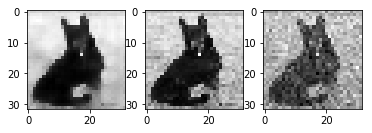

In [33]:
#Example results of image reconstruction from latent vector (32*32)/128
#Decent results but much room for improvement

plt.subplot(1,3,1)
plt.imshow(x_decoded[30].squeeze(),cmap = "gray")
plt.subplot(1,3,2)
plt.imshow(x_test[30].squeeze(),cmap = "gray")
plt.subplot(1,3,3)
plt.imshow(x_test_noisy[30].squeeze(),cmap = "gray")


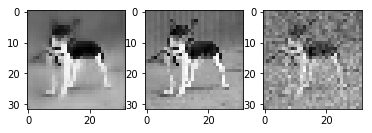

In [34]:
plt.subplot(1,3,1)
plt.imshow(x_decoded[560].squeeze(),cmap = "gray")
plt.subplot(1,3,2)
plt.imshow(x_test[560].squeeze(),cmap = "gray")
plt.subplot(1,3,3)
plt.imshow(x_test_noisy[560].squeeze(),cmap = "gray")

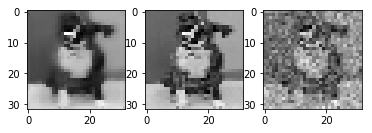

In [35]:
plt.subplot(1,3,1)
plt.imshow(x_decoded[300].squeeze(),cmap = "gray")
plt.subplot(1,3,2)
plt.imshow(x_test[300].squeeze(),cmap = "gray")
plt.subplot(1,3,3)
plt.imshow(x_test_noisy[300].squeeze(),cmap = "gray")

In [36]:
autoencoder.save('autoencoder.h5')
autoencoder.save_weights('autoencoder_weights.h5')

# 